# ***Lite U-Net++ Architecture*** for *semantic segmentation*

<p align="center">
  <img src="Images/NestedUNet.png" alt="Nested U-Net" title = "U-Net ++/ Nested U-Net" width="600"/> <br>
  <em> U-Net ++/ Nested U-Net Architecture </em>
</p>

- Nested U-Net is motivated by the U-Net backbone for image segmentation tasks. It was uniquely designed with Dense Connections and Deep Supervision. 
- *Dense Connection* allows all layers to have direct access to the gradients in loss function, since the consecutive node is created by concatenation of the prior layers. This helps the model to learn better and improves communication between layers at different stages.
- *Deep Supervision* allows the stage 0 nodes to all have the capability to produce segmented outputs. Therefore, during inference, time can be reduced if we use the output of a shallower node.

<p align="center">
  <img src="Images/Functions.png" alt="Dense connection" width="600"/> <br>
  <em> Dense Connection </em>
</p>

Formula for the dense connection in ***Nested U-Net***:
$$
x^{(i,j)} =
\begin{cases}
  \mathcal{H}\!\left(x^{(i-1,j)}\right), & j=0, \\[6pt]
  \mathcal{H}\!\left(\left[\,\{x^{(i,k)}\}_{k=0}^{j-1},\; \mathcal{U}\!\left(x^{(i+1,j-1)}\right)\right]\right), & j>0
\end{cases}
$$

With:
- $\mathcal{U}(\cdot)$: Upsampling operation  
- $\mathcal{H}(\cdot)$: Convolution + activation  
- $[\cdot]$: Concatenation


## Importing libraries and modules

In [19]:
#---Importing---
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import v2
import cv2
import random
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
import torchvision.io as io
from torchsummary import summary
from scipy import ndimage as ndi
from tqdm import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"

### *Group Normalization / Batch Normalization / Instance Normalization*

In [20]:
# --- Versatile Normalization fucntion ---
def get_norm(num_channels, kind="gn", num_groups=8):
    if kind == "gn":
        # choose a divisor of num_channels
        g = min(num_groups, num_channels)
        while g > 1 and (num_channels % g) != 0:
            g -= 1
        return nn.GroupNorm(g, num_channels)
    elif kind == "in":
        return nn.InstanceNorm2d(num_channels, affine=True, track_running_stats=False)
    elif kind == "bn":
        return nn.BatchNorm2d(num_channels)
    else:
        raise ValueError(f"Unknown norm kind: {kind}")

### *Squeeze and Excitation Block*

<p align="center">
  <img src="Images/SEBlock.jpg" alt="SE Block" width="400"/> <br>
  <em> SE Block </em>
</p>

In [21]:
class SE(nn.Module):
    def __init__(self, in_channels, out_channels, reduction = 4):
        super(SE, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_channels, out_features=out_channels//reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=out_channels//reduction, out_features=out_channels),
            nn.Sigmoid()
        )
    def forward(self, input_map):
        x = self.squeeze(input_map)
        x = self.excitation(x).unsqueeze(-1).unsqueeze(-1) #[B,C]->[B,C,1,1], unsqueeze(-1) means to unsqueeze the last dim
        return input_map*x

## U-Lite inpsired **Convolution Blocks**

<p align="center">
  <img src="Images/AxialConv.png" alt="Axial Convolution" width = "40%"/> <br>
  <em> Single Axial DW Convolution </em>
</p>

### *Axial Depth-wise Convolution*

In [22]:
class AxialConvDW(nn.Module):
    def __init__ (self, in_channels, axial_size = 7, dilation=1):
        super(AxialConvDW,self).__init__()

        padding = ((axial_size-1)//2)*dilation

        self.horizontal_conv = nn.Conv2d(in_channels, in_channels, 
            kernel_size=(1,axial_size), stride=1, padding = (0,padding), 
            groups=in_channels, dilation=dilation)
        
        self.vertical_conv = nn.Conv2d(in_channels, in_channels, 
            kernel_size=(axial_size,1), stride=1, padding = (padding,0), 
            groups=in_channels, dilation=dilation)
        
    def forward(self, x):
        return x+self.horizontal_conv(x)+self.vertical_conv(x)

### *Single Axial Depth-wise Convolution Block*

In [23]:
class SDWConv (nn.Module):
    def __init__ (self, in_channels, out_channels, axial_size = 3, dilation=1, act = 'gelu', norm = 'gn'):
        super().__init__()
        self.conv = nn.Sequential(
            AxialConvDW(in_channels=in_channels,axial_size=axial_size,dilation=dilation),
            get_norm(in_channels,kind=norm),
            nn.Conv2d(in_channels, out_channels, 1, 1),
            nn.GELU() if act == 'gelu' else nn.ReLU(inplace = True))
    def forward(self, x):
        return self.conv(x)

### *Double Axial Depth-wise Convolution Block*

<p align="center">
  <img src="Images/DoubleSDWConv.png" alt="Double SDW Convolution"/> <br>
  <em> Double Axial DW Convolution </em>
</p>

In [24]:
class DoubleSDWConv (nn.Module):
    def __init__ (self, in_channels, out_channels, axial_size = 3, dilation = 1, act = 'gelu'):
        super().__init__()
        self.conv1 = SDWConv(in_channels, out_channels, axial_size, dilation, act)
        self.conv2 = SDWConv(out_channels, out_channels, axial_size, dilation, act)
        self.se = SE(out_channels, out_channels,reduction=6)
    def forward(self, x):
        return self.se(self.conv2(self.conv1(x)))

### *U-Lite Bottleneck*

<p align="center">
  <img src="Images/UliteBottleneck.png" alt="Ulite Bottleneck" width = '70%'/> <br>
  <em> U-Lite Bottleneck </em>
</p>

In [25]:
class BottleNeck(nn.Module):
    def __init__ (self, in_channels, mid_channels):
        super(BottleNeck, self).__init__()
        self.pw1 = nn.Conv2d(in_channels, mid_channels//4, kernel_size=1, stride = 1)
        self.dw1 = AxialConvDW(mid_channels//4, dilation=1)
        self.dw2 = AxialConvDW(mid_channels//4, dilation=2)
        self.dw3 = AxialConvDW(mid_channels//4, dilation=3)
        self.bn = nn.BatchNorm2d(mid_channels)
        self.pw2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=1, stride = 1)
        self.gelu = nn.GELU()
        self.se = SE(mid_channels,mid_channels,reduction=4)

    def forward(self, x):
        x = self.pw1(x)
        x = torch.cat([x,self.dw1(x),self.dw2(x),self.dw3(x)], dim=1)
        x = self.gelu(self.pw2(self.bn(x)))
        return self.se(x)

## Ordinary **Convolution Blocks**

### *Single Convolution Block*
- A simple convolution block involves convolution layer, followed by a batch normalization and an acitvation function.

In [26]:
class SingleConv(nn.Module):
    def __init__ (self, in_ch, out_ch, kernel_size = 3):
        super().__init__()
        self.flow = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride = 1, padding = 'same'), #For changes in spatial size (Downsample)
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.flow(x)

### *Double Convolution Block*

In [27]:
class DoubleConv(nn.Module):
    def __init__ (self, in_ch, out_ch, kernel_size = 3):
        super().__init__()
        self.flow = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride = 1, padding = 'same'), #For changes in spatial size (Downsample)
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride=1, padding = 'same'),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.flow(x)

### *Simple Bottleneck*
- Basically just a double convolution block

In [28]:
class OGBottleNeck(nn.Module):
    def __init__ (self, in_channels, mid_channels, padding = 1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding = padding, stride = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding = padding, stride = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

## Flexible class to call any Convolution block

In [29]:
class ConvLayer(nn.Module):
    def __init__ (self, conv_layer, *args, **kwargs):
        super().__init__()
        self.layer = conv_layer(*args, **kwargs)
    def forward(self,x):
        return self.layer(x)

## ***U-Net++*** 

In [30]:
class NestedUNet(nn.Module):
    def __init__ (self, num_classes = 1, in_channels = 3, planes = [32,64,128,256,512], deep_supervision = True):
        super().__init__()
        
        self.down_sample = nn.MaxPool2d(2,2)
        self.up_sample =  nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=False)
        self.deep_supervision = deep_supervision

        self.X_00 = nn.Sequential(
            ConvLayer(nn.Conv2d,in_channels=in_channels,out_channels=planes[0],kernel_size = 7, stride = 1, padding = 3),
            ConvLayer(DoubleConv,in_ch=planes[0],out_ch=planes[0])
        )
        self.X_10 = ConvLayer(DoubleConv,planes[0],planes[1])
        self.X_20 = ConvLayer(DoubleConv,planes[1],planes[2])
        self.X_30 = ConvLayer(DoubleConv,planes[2],planes[3])
        
        self.X_40 = OGBottleNeck(planes[3],planes[4])

        self.X_01 = ConvLayer(SingleConv,planes[0]+planes[1],planes[0])
        self.X_11 = ConvLayer(SingleConv,planes[1]+planes[2],planes[1])
        self.X_21 = ConvLayer(SingleConv,planes[2]+planes[3],planes[2])
        self.X_31 = ConvLayer(DoubleConv,planes[3]+planes[4],planes[3])

        self.X_02 = ConvLayer(SingleConv,planes[0]*2+planes[1],planes[0])
        self.X_12 = ConvLayer(SingleConv,planes[1]*2+planes[2],planes[1])
        self.X_22 = ConvLayer(DoubleConv,planes[2]*2+planes[3],planes[2])

        self.X_03 = ConvLayer(SingleConv,planes[0]*3+planes[1],planes[0])
        self.X_13 = ConvLayer(DoubleConv,planes[1]*3+planes[2],planes[1])

        self.X_04 = ConvLayer(DoubleConv,planes[0]*4+planes[1],planes[0])

        self.final1 = nn.Conv2d(planes[0],num_classes,1)
        self.final2 = nn.Conv2d(planes[0],num_classes,1)
        self.final3 = nn.Conv2d(planes[0],num_classes,1)
        self.final4 = nn.Conv2d(planes[0],num_classes,1)

    def forward (self, input):
        x00 = self.X_00(input)
        x10 = self.X_10(self.down_sample(x00))
        x20 = self.X_20(self.down_sample(x10))
        x30 = self.X_30(self.down_sample(x20))
        x40 = self.X_40(self.down_sample(x30))

        x01 = self.X_01(torch.cat([x00,self.up_sample(x10)],dim = 1))
        x11 = self.X_11(torch.cat([x10,self.up_sample(x20)],dim = 1))
        x21 = self.X_21(torch.cat([x20,self.up_sample(x30)],dim = 1))
        x31 = self.X_31(torch.cat([x30,self.up_sample(x40)],dim = 1))

        x02 = self.X_02(torch.cat([x00,x01,self.up_sample(x11)],dim = 1))
        x12 = self.X_12(torch.cat([x10,x11,self.up_sample(x21)],dim = 1))
        x22 = self.X_22(torch.cat([x20, x21,self.up_sample(x31)],dim = 1))

        x03 = self.X_03(torch.cat([x00,x01,x02,self.up_sample(x12)],dim = 1))
        x13 = self.X_13(torch.cat([x10,x11,x12,self.up_sample(x22)],dim = 1))

        x04 = self.X_04(torch.cat([x00,x01,x02,x03,self.up_sample(x13)],dim = 1))

        if self.deep_supervision:
            output1 = self.final1(x01)
            output2 = self.final2(x02)
            output3 = self.final3(x03)
            output4 = self.final4(x04)
            return [output1, output2, output3, output4]
        else:
            output = self.final4(x04) # [N,1,H,W], one batch at a time
            return output

### Run test on U-Net++ and evaluate number of parameters

In [31]:
if __name__ == "__main__":
    inputs = torch.randn((8, 3, 128,128))
    model = NestedUNet()
    outputs = model(inputs)
    print(outputs[0].shape)
    summary(model, (3,128,128))

torch.Size([8, 1, 128, 128])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 128, 128]        --
|    └─ConvLayer: 2-1                    [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 128, 128]        4,736
|    └─ConvLayer: 2-2                    [-1, 32, 128, 128]        --
|    |    └─DoubleConv: 3-2              [-1, 32, 128, 128]        18,624
├─MaxPool2d: 1-2                         [-1, 32, 64, 64]          --
├─ConvLayer: 1-3                         [-1, 64, 64, 64]          --
|    └─DoubleConv: 2-3                   [-1, 64, 64, 64]          --
|    |    └─Sequential: 3-3              [-1, 64, 64, 64]          55,680
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─ConvLayer: 1-5                         [-1, 128, 32, 32]         --
|    └─DoubleConv: 2-4                   [-1, 128, 32, 32]         --
|    |    └─Sequential: 3-4              [-1,

## ***Lite U-Net++***, inspired by the design of *U-Lite*

In [32]:
class LiteNestedUNet (nn.Module):
    def __init__ (self, num_classes = 1, in_channels = 3, 
                  planes = [32,64,128,256, 512], deep_supervision = True):
        super().__init__()
        
        self.down_sample = nn.MaxPool2d(2,2)
        self.up_sample =  nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=False)
        self.deep_supervision = deep_supervision
        self.gelu = nn.GELU()

        self.X_00 = ConvLayer(DoubleSDWConv,in_channels, planes[0], axial_size = 3)
        self.X_10 = ConvLayer(DoubleSDWConv,planes[0],planes[1],axial_size = 3)
        self.X_20 = ConvLayer(DoubleSDWConv,planes[1],planes[2],axial_size = 5)
        self.X_30 = ConvLayer(DoubleSDWConv,planes[2],planes[3],axial_size = 5)

        self.X_40 = BottleNeck(planes[3],planes[4])

        self.X_01 = ConvLayer(SDWConv,planes[0]+planes[1],planes[0],axial_size=3)
        self.X_11 = ConvLayer(SDWConv,planes[1]+planes[2],planes[1],axial_size=3)
        self.X_21 = ConvLayer(SDWConv,planes[2]+planes[3],planes[2],axial_size=5)
        self.X_31 = ConvLayer(DoubleSDWConv,planes[3]+planes[4],planes[3],axial_size = 5)

        self.X_02 = ConvLayer(SDWConv,planes[0]*2+planes[1],planes[0],axial_size=3)
        self.X_12 = ConvLayer(SDWConv,planes[1]*2+planes[2],planes[1],axial_size=3)
        self.X_22 = ConvLayer(DoubleSDWConv,planes[2]*2+planes[3],planes[2],axial_size=5)

        self.X_03 = ConvLayer(SDWConv,planes[0]*3+planes[1],planes[0],axial_size=3)
        self.X_13 = ConvLayer(DoubleSDWConv,planes[1]*3+planes[2],planes[1],axial_size=3)

        self.X_04 = ConvLayer(DoubleSDWConv,planes[0]*4+planes[1],planes[0],axial_size=3)

        self.final1 = nn.Conv2d(planes[0],num_classes,1)
        self.final2 = nn.Conv2d(planes[0],num_classes,1)
        self.final3 = nn.Conv2d(planes[0],num_classes,1)
        self.final4 = nn.Conv2d(planes[0],num_classes,1)

    def forward (self, input):
        x00 = self.X_00(input)
        x10 = self.X_10(self.down_sample(x00))
        x20 = self.X_20(self.down_sample(x10))
        x30 = self.X_30(self.down_sample(x20))
        x40 = self.X_40(self.down_sample(x30))

        x01 = self.X_01(torch.cat([x00,self.up_sample(x10)],dim = 1))
        x11 = self.X_11(torch.cat([x10,self.up_sample(x20)],dim = 1))
        x21 = self.X_21(torch.cat([x20,self.up_sample(x30)],dim = 1))
        x31 = self.X_31(torch.cat([x30,self.up_sample(x40)],dim = 1))

        x02 = self.X_02(torch.cat([x00,x01,self.up_sample(x11)],dim = 1))
        x12 = self.X_12(torch.cat([x10,x11,self.up_sample(x21)],dim = 1))
        x22 = self.X_22(torch.cat([x20, x21,self.up_sample(x31)],dim = 1))

        x03 = self.X_03(torch.cat([x00,x01,x02,self.up_sample(x12)],dim = 1))
        x13 = self.X_13(torch.cat([x10,x11,x12,self.up_sample(x22)],dim = 1))

        x04 = self.X_04(torch.cat([x00,x01,x02,x03,self.up_sample(x13)],dim = 1))
        
        if self.deep_supervision: 
            #self.training to ensure that the model is in 'train' mode
            #self.training is a boolean attribute of torch.nn.Module that indicates whether the module is currently in training mode or evaluation (inference) mode.
            output1 = self.final1(x01)
            output2 = self.final2(x02)
            output3 = self.final3(x03)
            output4 = self.final4(x04)
            return [output1, output2, output3, output4]
        else:
            output = self.final4(x04) # [N,1,H,W], one batch at a time
            return output

### Run test on Lite U-Net++ and evaluate number of parameters

In [33]:
if __name__ == "__main__":
    inputs = torch.randn((8, 3, 128,128))
    model = LiteNestedUNet()
    model.eval()
    model.deep_supervision = False
    outputs = model(inputs)
    print(outputs.size())
    summary(model, (3,128,128))

torch.Size([8, 1, 128, 128])
Layer (type:depth-idx)                        Output Shape              Param #
├─ConvLayer: 1-1                              [-1, 32, 128, 128]        --
|    └─DoubleSDWConv: 2-1                     [-1, 32, 128, 128]        --
|    |    └─SDWConv: 3-1                      [-1, 32, 128, 128]        158
|    |    └─SDWConv: 3-2                      [-1, 32, 128, 128]        1,376
|    |    └─SE: 3-3                           [-1, 32, 128, 128]        357
├─MaxPool2d: 1-2                              [-1, 32, 64, 64]          --
├─ConvLayer: 1-3                              [-1, 64, 64, 64]          --
|    └─DoubleSDWConv: 2-2                     [-1, 64, 64, 64]          --
|    |    └─SDWConv: 3-4                      [-1, 64, 64, 64]          2,432
|    |    └─SDWConv: 3-5                      [-1, 64, 64, 64]          4,800
|    |    └─SE: 3-6                           [-1, 64, 64, 64]          1,354
├─MaxPool2d: 1-4                              [-1, 6

### Calculate GFLOPs of model

In [34]:
from ptflops import get_model_complexity_info

model = LiteNestedUNet(deep_supervision=False).eval()
mac, params = get_model_complexity_info(model, (3,128,128),
                                        as_strings=False,
                                        print_per_layer_stat=False)
print(f"Params: {params/1e6:.2f} M")
print(f"MACs: {mac/1e9:.2f} GMac")
print(f"FLOPs: {2*mac/1e9:.2f} GFLOPs")

Params: 1.14 M
MACs: 1.06 GMac
FLOPs: 2.11 GFLOPs


## **Data Science Bowl (DSB) 2018 Nuclei dataset**

In [35]:
TRAIN_DIR = '../data_temp/DSB_2018/data-science-bowl-2018/stage1_train'
TRAIN_MASKS_DIR = '../data_temp/DSB_2018/data-science-bowl-2018/stage1_train_combinedmasks'
TEST_DIR = '../data_temp/DSB_2018/data-science-bowl-2018/stage1_test'

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [36]:
train_dirs = next(os.walk(top = TRAIN_DIR, topdown=True))[1]
test_dirs = next(os.walk(top = TEST_DIR, topdown=True))[1]
masks_filenames = next(os.walk(top=TRAIN_MASKS_DIR,topdown=True))[2]

- `os.walk()` returns **directory path** (path to the folder), **sub-directory** (sub-folders) names and **file names**

- Split train dataset into *train and evaluation set, 80:20*

In [37]:
train_dirs = next(os.walk(top = TRAIN_DIR, topdown=True))[1]
train_ids, eval_ids = train_test_split(train_dirs, test_size=0.2, shuffle=True, random_state=18)

### **Custom class for DSB 2018** nuclei dataset

In [38]:
class DSB2018_Dataset (torch.utils.data.Dataset):
    def __init__ (self, set_type, 
                  size = (IMG_HEIGHT, IMG_WIDTH), 
                  joint_transform = None, 
                  train_ids = train_ids, 
                  eval_ids = eval_ids, 
                  binary_mask = True,
                  distance_map = False,
                  clip_dist = None,
                  normalize_phi = True):
        
        self.joint_transform = joint_transform
        self.binary_mask = binary_mask
        self.distance_map = distance_map
        self.clip_dist = clip_dist
        self.normalize_phi = normalize_phi

        # Check for dataset type and assign correct list of sample ids (folder names)
        if set_type.lower() == 'train':
            self.data_ids = train_ids  
        elif set_type.lower() == 'eval':
            self.data_ids = eval_ids
        else: raise ValueError('Dataset type must be \'train\' or \'eval\'.')

        self.img_resize = v2.Resize(size=size, interpolation=v2.InterpolationMode.BILINEAR)
        self.mask_resize = v2.Resize(size=size, interpolation=v2.InterpolationMode.NEAREST_EXACT)
        self.to_float01 = v2.ToDtype(torch.float32,scale=True) #Normalize to [0,1]

    def __len__(self):
        return len(self.data_ids)
    
    
    def __distance_transform__ (self, mask):
        '''
        Distance map is needed for boundary-related loss.
        Set boolean self.distance_map.
        If True then phi and D are returned in addition with image and mask.
        '''
        mk = mask[0].cpu().numpy().astype(np.uint8) #[1,H,W]->[H,W]
        # _edt means Euclidean distance transform 
        inner_distance = ndi.distance_transform_edt(mk) #This returns the distance to the nearest zero-element
        outer_distance = ndi.distance_transform_edt(1-mk)
        
        phi = outer_distance-inner_distance #Positive outside of the foreground, negative on the inside
        D = np.abs(phi)

        if self.clip_dist is not None:
            phi = np.clip(phi,-self.clip_dist,self.clip_dist)
            D   = np.clip(D,0.0,self.clip_dist)

        if self.normalize_phi:
            abs_mean = np.mean(np.abs(phi)) + 1e-8
            phi = phi / abs_mean

        phi = torch.from_numpy(phi).unsqueeze(0).to(mask.dtype)
        D = torch.from_numpy(D).unsqueeze(0).to(mask.dtype)

        return phi,D
    
    def __getitem__(self, index):

        img_id = self.data_ids[index]
        img_path = os.path.join(TRAIN_DIR, img_id, 'images', f'{img_id}.png')
        mask_path =  os.path.join(TRAIN_MASKS_DIR, f'{img_id}.png')

        image = io.decode_image(img_path, mode= 'RGB')
        mask = io.decode_image(mask_path, mode = 'GRAY')

        if self.joint_transform is not None:
            image, mask = self.joint_transform(image, mask)

            if self.distance_map and self.binary_mask:
                phi,D = self.__distance_transform__(mask)
                return image, mask, phi, D
            
            return image, mask
        else:
            image = self.img_resize(image)
            image = self.to_float01(image)
            
            mask = self.mask_resize(mask)
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
            
           # ---Mask binarization & handling dtype--- (Last for safety)
            if self.binary_mask:
                mask = (mask>0).to(torch.float32) 
            else: # Multi-class segment, which would expect mask to be of long dtype
                mask = mask.to(torch.long)
            
            if self.distance_map and self.binary_mask:
                phi,D = self.__distance_transform__(mask)
                return image, mask, phi, D

            return image, mask


### Data augmentation

In [39]:
class JointTransform: 
# Takes both numpy and torch tensors
    def __init__(self, resize = (IMG_HEIGHT+32, IMG_WIDTH+32), size = (IMG_HEIGHT,IMG_WIDTH), binary_mask = True):
        self.size = size #True size
        self.normalize = v2.Normalize(mean = [0.485, 0.456, 0.406], 
                                      std = [0.229, 0.224, 0.225])
        self.img_resize = v2.Resize(size=resize, interpolation=v2.InterpolationMode.BILINEAR)#Resizing size is bigger because we want to perform random crop
        self.mask_resize = v2.Resize(size=resize, interpolation=v2.InterpolationMode.NEAREST_EXACT)
        self.to_float01 = v2.ToDtype(torch.float32,scale=True) #Normalize to [0,1]
        self.binary_mask = binary_mask
    
    def _to_torch_tensor(self, input): # Accept both numpy arrays and tensors
        if isinstance(input, np.ndarray):
            tensor = torch.from_numpy(input) #(H,W,C) - numpy array or (H,W)
            if tensor.ndim == 2: #(H,W)
                tensor = tensor.unsqueeze(-1) #(H,W,1)
            tensor = tensor.permute(2,0,1)
        else: # Tensor (C,H,W)
            tensor = input
            if tensor.ndim == 2: #(H,W)
                tensor = tensor.unsqueeze(0) #(1,H,W)
        return tensor
        
    def __call__(self, image, mask):
        #Convert ndarray to tensor
        image = self._to_torch_tensor(image)
        image = self.to_float01(image)

        mask = self._to_torch_tensor(mask)
        mask = mask[:1,:,:] #Ensure that mask has only one channel

        # ---Resizing---
        image = self.img_resize(image)
        mask = self.mask_resize(mask)

        # ---Random crop---
        # i,j are the coordinates that signifies where to start cropping
        i,j,h,w = v2.RandomCrop.get_params(image, output_size=self.size)
        image = F.crop(image, i,j,h,w)
        mask = F.crop(mask, i,j,h,w)
        
        # ---Random horizontal flip---
        if random.random() > 0.5:
            image = F.hflip(image)
            mask = F.hflip(mask)
        
        # ---Random vertical flip---
        if random.random() > 0.5:
            image = F.vflip(image)
            mask = F.vflip(mask)
        
        # ---Random rotation---
        if random.random() > 0.5:
            angle = random.uniform(-10, 10)
            image = F.rotate(image, angle=angle,
                             interpolation=v2.InterpolationMode.BILINEAR, fill = 0.0)
            mask = F.rotate(mask, angle=angle, 
                            interpolation=v2.InterpolationMode.NEAREST)

        # ---Mask binarization & handling dtype--- (Last for safety)
        if self.binary_mask:
            mask = (mask>0).to(torch.float32) 
        else: # Multi-class segment, which would expect mask to be of long dtype
            mask = mask.to(torch.long)

        # ---Normalized the image---
        image = self.normalize(image)
        
        '''
        Size:[1,H,W]
        '''
        return image, mask

### Illustration of the DSB 2018 dataset

torch.Size([16, 3, 128, 128]) torch.Size([16, 1, 128, 128])
Current index: 0


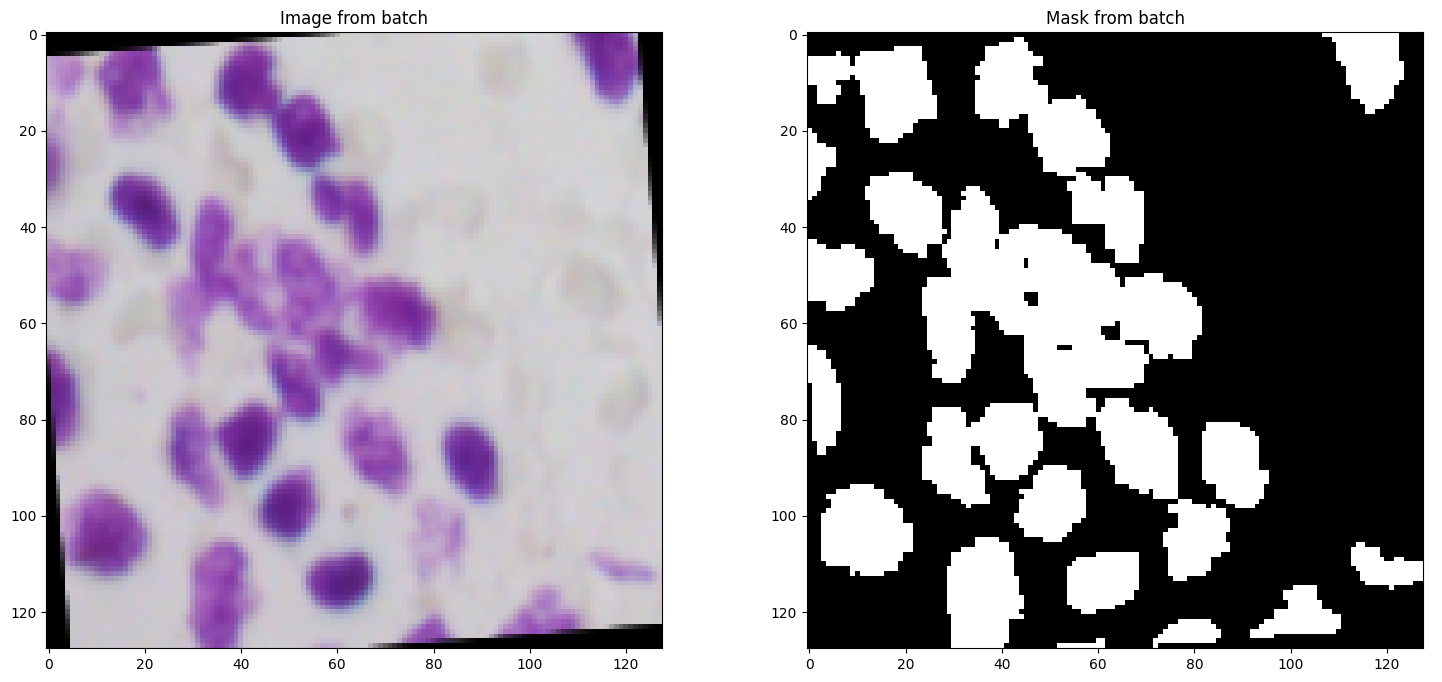

In [84]:
# Test the custom class with DataLoader
train_data = DSB2018_Dataset(set_type='train', 
                             joint_transform= JointTransform(),
                             distance_map=True,
                             binary_mask=True)
trn_dl = DataLoader(train_data, batch_size = 16, shuffle = True)
img, mk, phi, D = next(iter(trn_dl))


# Assume img is a tensor with shape (1, 3, 224, 224)
a = random.randint(0,11)
img_rgb = img[a]  # Remove batch dimension → shape: (3, 224, 224)
mask_gray = mk[a]

# Convert from (C, H, W) → (H, W, C)
img_rgb = img_rgb.permute(1, 2, 0).numpy()  # shape: (224, 224, 3)
mask_gray = mask_gray.permute(1,2,0).numpy() 
# Denormalize if it was normalized (e.g., ImageNet normalization)

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
img_rgb = img_rgb * std + mean
img_rgb = np.clip(img_rgb, 0, 1) # CLipping the array into [0,1]

# Scale to [0,255] and convert to uint8
img_rgb = (img_rgb * 255).astype(np.uint8)
mask_gray = mask_gray.astype(np.uint8)

# Convert to PIL and show
plt.figure(figsize = (18,8))
plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(img_rgb) #plt.imshow() can function with range [0,1] as float32 and [0,255] as uint8
plt.title('Image from batch')

plt.subplot(1,2,2)
plt.imshow(mask_gray, cmap= 'gray') #12 classes in total => The class 11 would be 1 (brightest) which is white.
# since [Normalized value = data-vmin/vmax - vmin]
# `vmin` and `vmax` control the mapping of data values to colors within a colormap. 
#They define the data range that the colormap will cover.
plt.title('Mask from batch')
print(img.shape, mk.shape)
print(f'Current index: {a}')

plt.show()

### Visualization of distance maps (for Boundary Loss), **$\phi$** and **D**

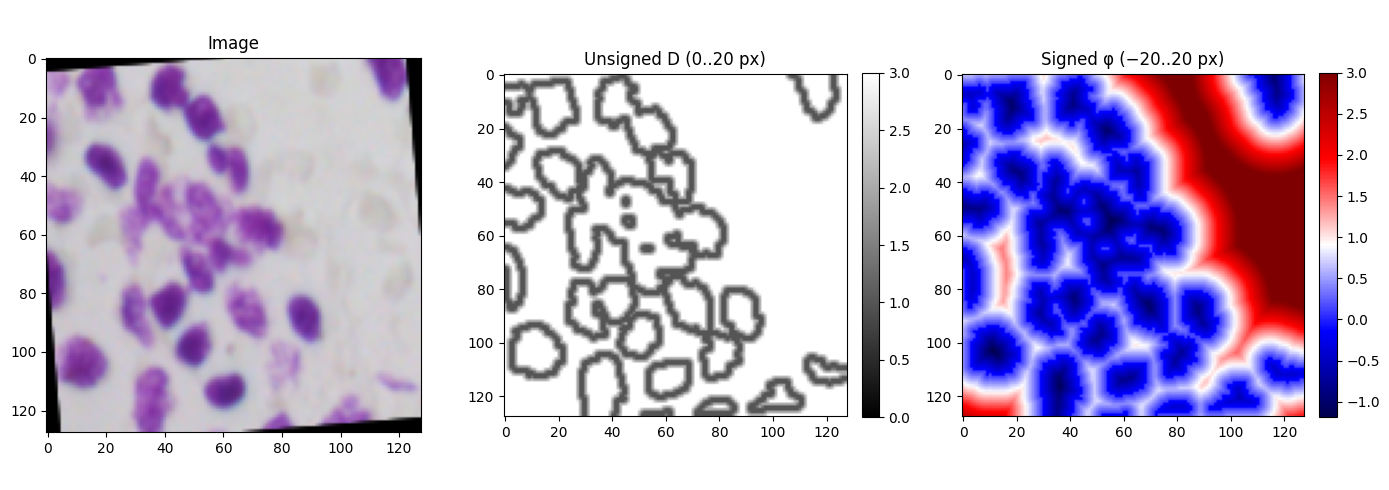

In [91]:
# img: [B,3,H,W], mask: [B,1,H,W], phi: [B,1,H,W], D: [B,1,H,W]

img_rgb = img[a].permute(1,2,0).cpu().numpy()  # [H,W,3], float

mean = np.array([0.485, 0.456, 0.406])[None,None,:]
std  = np.array([0.229, 0.224, 0.225])[None,None,:]
img_vis = np.clip(img_rgb * std + mean, 0, 1)

# ---Distance maps---
D2d   = D[a, 0].cpu().numpy()      # [H,W]
phi2d = phi[a, 0].cpu().numpy()    # [H,W]

# Clipped band for better display
T = 3
D_band = np.clip(D2d, 0, T)      
# For signed phi, keep 0 centered:
phi_clip = np.clip(phi2d, -T, T)

plt.figure(figsize=(14,5)); plt.axis('off')
plt.subplot(1,3,1); plt.imshow(img_vis); plt.title('Image')
plt.subplot(1,3,2); plt.imshow(D_band, cmap='gray', vmin=0, vmax=T); plt.title('Unsigned D (0..20 px)'); plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,3); plt.imshow(phi_clip, cmap='seismic'); plt.title('Signed φ (−20..20 px)'); plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


## ***Loss functions and Metrics***

### **Dice score** and **IoU** to evaluate semantic segmentation

- **Dice score** is defined as:
$$
\text{Dice score} = \frac{2\times\text{TP}}{(\text{TP}+\text{FP})+(\text{TP}+\text{FN})+\epsilon}
$$
- **IoU** (Intersection over Union) is defined as:
$$
\text{IoU} = \frac{\text{Dice score}}{2-\text{Dice score} + \epsilon}
$$

In [42]:
def Dice_IoU(pred, mask, epsilon = 1e-6):
    # Case 1: Pred's shape is [N,2,H,W], binary is 2 classes, this was treated like multi class segmentation
    if pred.ndim == 4 and pred.shape[1]==2:
        pred = pred.argmax(dim = 1).unsqueeze(1) # [N,2,H,W] -> [N,H,W]

    # Case 2: Pred's shape is [N,H,W] -> [N,1,H,W]
    elif pred.ndim == 4:
        pred = pred.squeeze(1) # [N,1,H,w] -> [N,H,W]
    
    pred = pred.to(torch.float32)

    if pred.dtype.is_floating_point and (pred.min()<0 or pred.max()>1): # Check if the pred pixel values are float, neccessary for sigmoid function
        pred = torch.sigmoid(pred)
        pred = (pred >= 0.5)

    mask = (mask > 0).to(torch.float32)

    intersection = (pred*mask).sum(dim=(1,2))
    union = pred.sum(dim=(1,2)) + mask.sum(dim=(1,2))
    
    dice = (2*intersection + epsilon)/(union + epsilon) # [N], dice score for each sample in the batch
    iou = dice/(2-dice +epsilon)

    return dice.mean().item(), iou.mean().item()

### **Focal loss**
**Focal loss** formula can be expressed as:
$$
\text{FL}(p_t) = -{\alpha}_t(1-p_t)^{\gamma}\log(p_t)
$$
$$
\text{Binary Cross Entropy Loss} = -\log(p_t)
$$
$$
\text{FL}(p_t) = {\alpha}_t(1-p_t)^{\gamma}(\text{BCE}(p_t))
$$
With:
- $\alpha_t$ is the balance factor to oppose class imbalance, for binary segmentation:
$$
\alpha_t =\begin{cases}\alpha, & y = 1 \\1 - \alpha, & y = 0\end{cases}
$$

In [43]:
'''---Focal Loss---'''
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma= 4/3, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Can be a list/tuple or scalar
        self.reduction = reduction

    def forward(self, pred, mask):
        '''
        logits: [B, H, W], mask: [B, H, W] 
        '''
        if pred.ndim==4 and pred.shape[1]==1: 
            pred = pred.squeeze(1) #[N,1,H,W] -> [N,H,W]
        elif pred.ndim != 3: 
            raise ValueError('Predicted logit is expected to be in the size [N,1,H,W] or [N,H,W]')

        if mask.ndim==4 and mask.shape[1]==1: 
            mask = mask.squeeze(1) # [N,1,H,W] -> [N,H,W]
        elif mask.ndim !=3: 
            raise ValueError('Ground truth mask is expected to be in the size [N,1,H,W] or [N,H,W]')
        
        mask = mask.to(torch.float32) # Ensure the right dtype of mask, BCE loss requires float

        bce = nn.functional.binary_cross_entropy_with_logits(pred, mask, reduction='none')  # [N,]
        pt = torch.exp(-bce)  # pt = prob of true class

        if self.alpha is not None:
            at = self.alpha*mask + (1-self.alpha)*(1-mask)
        else: at = 1.0

        loss = (at*(1 - pt) ** self.gamma *(bce))

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        
        return loss  # no reduction

### **Focal Tversky Loss**:
- Tversky Loss but powered by $1/\gamma$
- According to the paper, $\gamma$ has found the most success at $4/3$
$$
\text{FTL(Focal Tversky loss)} = \frac{1}{\text{C}}\sum_{c=1}^{C}(1-\text{Tversky}_c)^{1/\gamma} = \frac{1}{\text{C}}\sum_{c=1}^{C}(1-\text{TI}_c)^{1/\gamma}
$$
$$
\text{TI}_c = \frac{\text{TP}}{\text{TP} + \alpha\cdot\text{FP} + \beta\cdot\text{FN} + \epsilon}
$$ 

In [44]:
'''---Focal Tversky Loss---'''
class FTL(nn.Module):
    def __init__(self, alpha = 0.7, beta = 0.3, gamma = 4/3, epsilon = 1e-6, from_logits = True, reduction = 'mean'):
        super(FTL, self).__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.from_logits = from_logits
        self.reduction = reduction
    
    def forward (self, pred, mask): 
        '''
        Both pred and mask are converted into tensors before passing in
        Mask's input shape: [N,H,W]
        Logits(Predicted image)'s shape: [N,1,H,W]
        logits: [N, H, W] (Raw information), mask: [N, H, W] 
        '''

        # Check for shape
        if pred.ndim==4 and pred.shape[1]==1:
            pred = pred[:,0,:,:] #[N,1,H,W] -> [N,H,W]
        elif pred.ndim != 3: 
            raise ValueError('Predicted logit is expected to be in the size [N,1,H,W] or [N,H,W]')

        if mask.ndim==4 and mask.shape[1]==1:
            mask = mask[:,0,:,:] # [N,1,H,W] -> [N,H,W]
        elif mask.ndim !=3: 
            raise ValueError('Ground truth mask is expected to be in the size [N,1,H,W] or [N,H,W]')
        
        # Datatypes
        pred = pred.to(torch.float32)
        mask = mask.to(torch.float32)

        # logits -> Probability
        if self.from_logits: 
            prob = torch.sigmoid(pred)
        else: prob = pred.clamp(0,1)
        
        # FTL
        tp = (prob*mask).sum(dim =(1,2)) #[N,]
        fp = (prob*(1.0-mask)).sum(dim=(1,2)) 
        fn = (mask*(1.0-prob)).sum(dim=(1,2))
        tversky_index = (tp+self.epsilon)/(tp+self.alpha*fp+self.beta*fn+self.epsilon) #[N,]
        loss = (1-tversky_index)**(1/self.gamma)
        
        # Reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        
        return loss  # no reduction

### **Boundary loss**
- Boundary loss is defined as:
$$
\mathcal{L}_{\text{boundary}}(\theta)
= \langle \phi_G, \; s_\theta \rangle
= \int_{\Omega} \phi_G(p) \, s_\theta(p) \, dp
$$
With:
- $\phi_G(p)$: signed distance map of the ground truth mask
- $s_\theta(p)$: predicted probability of the true class

In [45]:
class BoundaryLoss(nn.Module):
    '''
    L = <phi_G, s_theta>
    - Binary: logits [N,1,H,W], phi [N,1,H,W]
    - Multi : logits [N,C,H,W], phi [N,C,H,W] (one phi per class)
    Expect phi already prepared (signed distance map in the custom dataset)
    '''
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction

    def forward(self, logits, phi):
        probs = torch.sigmoid(logits) if logits.shape[1] == 1 else F.softmax(logits, dim=1)
        loss_map = probs * phi                      # <phi, s>
        loss = loss_map.mean(dim=(1,2,3))          # per-sample [N,]
        
        if self.reduction == "mean": 
            return loss.mean()
        if self.reduction == "sum":  
            return loss.sum()
        return loss

### Function that gets all the neccessary model, functions, optimizer for training

In [46]:
def get_model(UNet = LiteNestedUNet,device = 'cuda',lr = 1e-3,weight_decay = 1e-5, optim = 'Adam', deep_supervision = True):
    
    #--- Model ---
    model = UNet(deep_supervision=deep_supervision).to(device)
    
    #--- Loss functions ---
    focal_tversky_loss = FTL(alpha = 0.3, beta=0.7, gamma=4/3)
    focal_loss = BCEFocalLoss(alpha=0.75, gamma=2) 
    boundary_loss = BoundaryLoss(reduction='mean')
    
    #--- Optimizers ---
    if optim == 'Adam':
        optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay) 
    elif optim == 'SGD':
        optimizer = SGD(model.parameters(), momentum=0.9, nesterov=True,lr = lr, weight_decay = weight_decay) 
    else: 
        raise ValueError('Unsupported Optimizer')
    
    return model, focal_tversky_loss, focal_loss, boundary_loss, optimizer

### Train batch function

In [47]:
def train_batch(model,data_batch,optimizer,
                focal_tversky_loss,focal_loss,boundary_loss,
                device = 'cuda', deep_supervision = True,
                head_weights = [0.1,0.1,0.2,0.6],
                w_bdry = 0.4, w_ftl = 0.6, w_fl = 0):
    model.train()
    
    img, mask, phi, D = data_batch
    img = img.to(device)
    mask = mask.to(device)
    phi = phi.to(device)
    D = D.to(device)
    
    if mask.ndim == 4 and mask.shape[1] == 1:
        mask = mask.squeeze(1)  # -> [N,H,W]
        
    mask = (mask > 0).to(torch.float32)

    optimizer.zero_grad()
    
    #---Deep supervision---
    if deep_supervision:
        logits = model(img) 
        total_loss = 0.0

        for logit, w in zip(logits,head_weights):
            loss = w_ftl*focal_tversky_loss(logit, mask) + w_fl*focal_loss(logit,mask) + w_bdry*boundary_loss(logit, phi)
            total_loss += loss*w

        total_loss.backward()
        optimizer.step() 

        final_logit = torch.stack(logits, dim=0).float().mean(dim=0) #Average of the deep supervision outputs
        final_pred = (torch.sigmoid(final_logit)>=0.5)
        dice, iou = Dice_IoU(final_pred,mask)
        pixel_acc = (final_pred==mask).float().mean()

        return total_loss.item(), dice, iou, pixel_acc
    
    #---Without deep supervision---
    else:
        logit = model(img)
        loss = w_ftl*focal_tversky_loss(logit, mask)  + w_fl*focal_loss(logits,mask)+ w_bdry*boundary_loss(logit, phi)

        loss.backward()
        optimizer.step()

        pred = (torch.sigmoid(logit.float())>=0.5) 
        dice, iou = Dice_IoU(pred,mask)
        pixel_acc = (pred==mask).float().mean()

        return loss.item(), dice, iou, pixel_acc
   

## ***Training***

In [48]:
train_data = DSB2018_Dataset(set_type='train', 
                             joint_transform= JointTransform(),
                             distance_map=True,
                             binary_mask=True)
trn_dl = DataLoader(train_data, batch_size = 16, shuffle = True)
img, mk, phi, D = next(iter(trn_dl))

In [49]:
#Warming up for boundary loss
def ramp_weight(epoch, start=3, end=15, max_w=0.2):
    if epoch < start:
        return 0.0
    if epoch >= end:
        return max_w
    # linear ramp
    return max_w * (epoch - start) / (end - start)

In [50]:
model, ftl, focal_loss, boundary_loss, optimizer = get_model(UNet=LiteNestedUNet, deep_supervision=True, lr=1e-3)
train_losses, train_dice_score, train_iou, train_accuracies = [],[],[],[]

epochs = 100

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor = 0.8,patience = 10, threshold=5e-3)

model.train()

img, mask, _,_ =next(iter(trn_dl))
print(img.shape, mask.shape)  # Should print torch.Size([B, 3, 224, 224]), torch.Size([B, 1, 224, 224])

head_weights = [0.1,0.1,0.2,0.6]

w_ftl = 0.7
w_fl = 0.3

for epoch in range(epochs):
    loss_sum = acc_sum = dice_sum = iou_sum = 0.0
    n = 0

    w_bdry = ramp_weight(epoch, start = 3, end = 15, max_w = 0.5)

    for batch in tqdm(trn_dl, desc=f'CURRENT EPOCH: {epoch}'):
        loss, dice, iou, acc = train_batch(model, batch, optimizer, 
                                      focal_tversky_loss=ftl, 
                                      focal_loss=focal_loss,
                                      boundary_loss=boundary_loss,
                                      head_weights=head_weights,
                                      w_ftl = w_ftl, w_fl = w_fl, w_bdry = w_bdry)
        
        # --- Convert to CPU and to float ---
        if torch.is_tensor(loss): loss = float(loss.detach().cpu())
        if torch.is_tensor(acc):  acc  = float(acc.detach().cpu())
        if torch.is_tensor(dice): dice = float(dice.detach().cpu())
        if torch.is_tensor(iou): iou = float(iou.detach().cpu())


        # train_batch should already return plain floats
        loss_sum += loss
        acc_sum  += acc
        dice_sum += dice
        iou_sum += iou
        n += 1

    epoch_loss = loss_sum / n
    epoch_acc  = acc_sum  / n
    epoch_dice = dice_sum / n
    epoch_iou = iou_sum / n

    train_losses.append(np.array(epoch_loss).item())
    train_accuracies.append(np.array(epoch_acc).item())
    train_dice_score.append(np.array(epoch_dice).item())
    train_iou.append(np.array(epoch_iou).item())

    scheduler.step(epoch_dice)

    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
    print(f'Epoch loss = {epoch_loss:.4f}, pixel accuracy = {epoch_acc*100:.4f}%')
    print(f'Dice score = {epoch_dice*100:.4f}%, IoU = {epoch_iou*100:.4f}%\n')


torch.Size([16, 3, 128, 128]) torch.Size([16, 1, 128, 128])


CURRENT EPOCH: 0: 100%|██████████| 34/34 [00:12<00:00,  2.69it/s]


Learning rate: 0.001000
Epoch loss = 0.4908, pixel accuracy = 42.4252%
Dice score = 45.9006%, IoU = 34.1741%



CURRENT EPOCH: 1: 100%|██████████| 34/34 [00:07<00:00,  4.77it/s]


Learning rate: 0.001000
Epoch loss = 0.3178, pixel accuracy = 67.8756%
Dice score = 79.2986%, IoU = 68.2100%



CURRENT EPOCH: 2: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


Learning rate: 0.001000
Epoch loss = 0.1847, pixel accuracy = 68.2422%
Dice score = 85.1042%, IoU = 75.8066%



CURRENT EPOCH: 3: 100%|██████████| 34/34 [00:07<00:00,  4.81it/s]


Learning rate: 0.001000
Epoch loss = 0.1622, pixel accuracy = 68.0326%
Dice score = 86.0690%, IoU = 77.1643%



CURRENT EPOCH: 4: 100%|██████████| 34/34 [00:06<00:00,  4.86it/s]


Learning rate: 0.001000
Epoch loss = 0.1510, pixel accuracy = 68.1893%
Dice score = 86.4443%, IoU = 77.6318%



CURRENT EPOCH: 5: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s]


Learning rate: 0.001000
Epoch loss = 0.1400, pixel accuracy = 68.1892%
Dice score = 87.0633%, IoU = 78.6009%



CURRENT EPOCH: 6: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s]


Learning rate: 0.001000
Epoch loss = 0.1337, pixel accuracy = 67.9596%
Dice score = 87.2408%, IoU = 78.7776%



CURRENT EPOCH: 7: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


Learning rate: 0.001000
Epoch loss = 0.1225, pixel accuracy = 68.6407%
Dice score = 88.0423%, IoU = 79.8172%



CURRENT EPOCH: 8: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.001000
Epoch loss = 0.1226, pixel accuracy = 68.3622%
Dice score = 87.7777%, IoU = 79.4663%



CURRENT EPOCH: 9: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s]


Learning rate: 0.001000
Epoch loss = 0.1163, pixel accuracy = 68.1948%
Dice score = 87.5755%, IoU = 79.2719%



CURRENT EPOCH: 10: 100%|██████████| 34/34 [00:06<00:00,  5.02it/s]


Learning rate: 0.001000
Epoch loss = 0.1064, pixel accuracy = 68.3780%
Dice score = 88.5299%, IoU = 80.3364%



CURRENT EPOCH: 11: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


Learning rate: 0.001000
Epoch loss = 0.1029, pixel accuracy = 68.2636%
Dice score = 88.3638%, IoU = 80.2444%



CURRENT EPOCH: 12: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Learning rate: 0.001000
Epoch loss = 0.0986, pixel accuracy = 68.4656%
Dice score = 88.3386%, IoU = 80.1428%



CURRENT EPOCH: 13: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


Learning rate: 0.001000
Epoch loss = 0.0931, pixel accuracy = 68.1296%
Dice score = 88.3861%, IoU = 80.2420%



CURRENT EPOCH: 14: 100%|██████████| 34/34 [00:06<00:00,  5.04it/s]


Learning rate: 0.001000
Epoch loss = 0.0879, pixel accuracy = 68.4288%
Dice score = 88.5978%, IoU = 80.4900%



CURRENT EPOCH: 15: 100%|██████████| 34/34 [00:06<00:00,  5.04it/s]


Learning rate: 0.001000
Epoch loss = 0.0833, pixel accuracy = 68.5475%
Dice score = 88.7209%, IoU = 80.6796%



CURRENT EPOCH: 16: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


Learning rate: 0.001000
Epoch loss = 0.0808, pixel accuracy = 68.4859%
Dice score = 88.9131%, IoU = 80.9321%



CURRENT EPOCH: 17: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


Learning rate: 0.001000
Epoch loss = 0.0826, pixel accuracy = 68.4905%
Dice score = 88.6002%, IoU = 80.6671%



CURRENT EPOCH: 18: 100%|██████████| 34/34 [00:06<00:00,  5.04it/s]


Learning rate: 0.001000
Epoch loss = 0.0825, pixel accuracy = 68.3157%
Dice score = 88.6167%, IoU = 80.6030%



CURRENT EPOCH: 19: 100%|██████████| 34/34 [00:06<00:00,  5.02it/s]


Learning rate: 0.001000
Epoch loss = 0.0801, pixel accuracy = 68.3025%
Dice score = 89.0913%, IoU = 81.0993%



CURRENT EPOCH: 20: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


Learning rate: 0.001000
Epoch loss = 0.0807, pixel accuracy = 68.1281%
Dice score = 88.8431%, IoU = 80.9532%



CURRENT EPOCH: 21: 100%|██████████| 34/34 [00:06<00:00,  4.86it/s]


Learning rate: 0.001000
Epoch loss = 0.0765, pixel accuracy = 68.4683%
Dice score = 89.0858%, IoU = 81.2166%



CURRENT EPOCH: 22: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.001000
Epoch loss = 0.0814, pixel accuracy = 68.3457%
Dice score = 88.7926%, IoU = 80.7695%



CURRENT EPOCH: 23: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Learning rate: 0.001000
Epoch loss = 0.0842, pixel accuracy = 68.3763%
Dice score = 88.8201%, IoU = 80.7354%



CURRENT EPOCH: 24: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.001000
Epoch loss = 0.0807, pixel accuracy = 68.3805%
Dice score = 88.8930%, IoU = 80.7790%



CURRENT EPOCH: 25: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Learning rate: 0.001000
Epoch loss = 0.0781, pixel accuracy = 68.5840%
Dice score = 89.2953%, IoU = 81.4909%



CURRENT EPOCH: 26: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s]


Learning rate: 0.001000
Epoch loss = 0.0769, pixel accuracy = 68.5265%
Dice score = 89.4107%, IoU = 81.5033%



CURRENT EPOCH: 27: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.001000
Epoch loss = 0.0789, pixel accuracy = 68.3108%
Dice score = 88.8603%, IoU = 80.9237%



CURRENT EPOCH: 28: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.001000
Epoch loss = 0.0807, pixel accuracy = 68.3438%
Dice score = 88.6933%, IoU = 80.7089%



CURRENT EPOCH: 29: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Learning rate: 0.001000
Epoch loss = 0.0784, pixel accuracy = 68.2619%
Dice score = 89.2321%, IoU = 81.4909%



CURRENT EPOCH: 30: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000800
Epoch loss = 0.0786, pixel accuracy = 68.3269%
Dice score = 89.1893%, IoU = 81.3961%



CURRENT EPOCH: 31: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000800
Epoch loss = 0.0774, pixel accuracy = 68.3679%
Dice score = 89.4600%, IoU = 81.7098%



CURRENT EPOCH: 32: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.000800
Epoch loss = 0.0742, pixel accuracy = 68.3050%
Dice score = 89.4133%, IoU = 81.5714%



CURRENT EPOCH: 33: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s]


Learning rate: 0.000800
Epoch loss = 0.0740, pixel accuracy = 68.5066%
Dice score = 89.6069%, IoU = 81.8616%



CURRENT EPOCH: 34: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000800
Epoch loss = 0.0756, pixel accuracy = 68.5217%
Dice score = 89.3214%, IoU = 81.5347%



CURRENT EPOCH: 35: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


Learning rate: 0.000800
Epoch loss = 0.0766, pixel accuracy = 68.4678%
Dice score = 89.6923%, IoU = 81.9253%



CURRENT EPOCH: 36: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


Learning rate: 0.000800
Epoch loss = 0.0736, pixel accuracy = 68.2150%
Dice score = 89.7130%, IoU = 81.9938%



CURRENT EPOCH: 37: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Learning rate: 0.000800
Epoch loss = 0.0731, pixel accuracy = 68.2534%
Dice score = 89.4667%, IoU = 81.7610%



CURRENT EPOCH: 38: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000800
Epoch loss = 0.0742, pixel accuracy = 68.4388%
Dice score = 89.6169%, IoU = 81.8565%



CURRENT EPOCH: 39: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


Learning rate: 0.000800
Epoch loss = 0.0728, pixel accuracy = 68.4354%
Dice score = 89.6073%, IoU = 81.9192%



CURRENT EPOCH: 40: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.000800
Epoch loss = 0.0742, pixel accuracy = 68.3846%
Dice score = 89.5826%, IoU = 81.8278%



CURRENT EPOCH: 41: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Learning rate: 0.000800
Epoch loss = 0.0743, pixel accuracy = 68.5416%
Dice score = 89.6396%, IoU = 81.8637%



CURRENT EPOCH: 42: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000800
Epoch loss = 0.0728, pixel accuracy = 68.4167%
Dice score = 89.5344%, IoU = 81.7605%



CURRENT EPOCH: 43: 100%|██████████| 34/34 [00:06<00:00,  4.90it/s]


Learning rate: 0.000800
Epoch loss = 0.0699, pixel accuracy = 68.2671%
Dice score = 89.7958%, IoU = 82.1460%



CURRENT EPOCH: 44: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s]


Learning rate: 0.000640
Epoch loss = 0.0749, pixel accuracy = 68.5334%
Dice score = 89.5903%, IoU = 81.9056%



CURRENT EPOCH: 45: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.000640
Epoch loss = 0.0735, pixel accuracy = 68.4491%
Dice score = 89.5170%, IoU = 81.7508%



CURRENT EPOCH: 46: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.000640
Epoch loss = 0.0737, pixel accuracy = 68.6896%
Dice score = 89.6474%, IoU = 81.9850%



CURRENT EPOCH: 47: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.000640
Epoch loss = 0.0724, pixel accuracy = 68.2578%
Dice score = 89.6907%, IoU = 81.9573%



CURRENT EPOCH: 48: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000640
Epoch loss = 0.0727, pixel accuracy = 68.5117%
Dice score = 89.4885%, IoU = 81.7928%



CURRENT EPOCH: 49: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000640
Epoch loss = 0.0710, pixel accuracy = 68.6533%
Dice score = 89.6930%, IoU = 82.0427%



CURRENT EPOCH: 50: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s]


Learning rate: 0.000640
Epoch loss = 0.0702, pixel accuracy = 68.2569%
Dice score = 89.6859%, IoU = 81.9950%



CURRENT EPOCH: 51: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s]


Learning rate: 0.000640
Epoch loss = 0.0723, pixel accuracy = 68.2902%
Dice score = 89.6402%, IoU = 81.9388%



CURRENT EPOCH: 52: 100%|██████████| 34/34 [00:06<00:00,  4.86it/s]


Learning rate: 0.000640
Epoch loss = 0.0733, pixel accuracy = 68.5107%
Dice score = 89.6528%, IoU = 82.0332%



CURRENT EPOCH: 53: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s]


Learning rate: 0.000640
Epoch loss = 0.0716, pixel accuracy = 68.4219%
Dice score = 89.6409%, IoU = 81.9484%



CURRENT EPOCH: 54: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


Learning rate: 0.000640
Epoch loss = 0.0700, pixel accuracy = 68.3250%
Dice score = 90.0357%, IoU = 82.4307%



CURRENT EPOCH: 55: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.000512
Epoch loss = 0.0712, pixel accuracy = 68.5721%
Dice score = 90.0441%, IoU = 82.3941%



CURRENT EPOCH: 56: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000512
Epoch loss = 0.0694, pixel accuracy = 68.5247%
Dice score = 89.9503%, IoU = 82.3134%



CURRENT EPOCH: 57: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s]


Learning rate: 0.000512
Epoch loss = 0.0711, pixel accuracy = 68.3401%
Dice score = 89.7093%, IoU = 82.0646%



CURRENT EPOCH: 58: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s]


Learning rate: 0.000512
Epoch loss = 0.0710, pixel accuracy = 68.5690%
Dice score = 89.9741%, IoU = 82.3887%



CURRENT EPOCH: 59: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Learning rate: 0.000512
Epoch loss = 0.0695, pixel accuracy = 68.4049%
Dice score = 90.0052%, IoU = 82.4769%



CURRENT EPOCH: 60: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000512
Epoch loss = 0.0719, pixel accuracy = 68.5276%
Dice score = 89.7422%, IoU = 82.0479%



CURRENT EPOCH: 61: 100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


Learning rate: 0.000512
Epoch loss = 0.0720, pixel accuracy = 68.6213%
Dice score = 89.8235%, IoU = 82.2844%



CURRENT EPOCH: 62: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Learning rate: 0.000512
Epoch loss = 0.0702, pixel accuracy = 68.4342%
Dice score = 89.9891%, IoU = 82.4958%



CURRENT EPOCH: 63: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000512
Epoch loss = 0.0687, pixel accuracy = 68.4765%
Dice score = 89.9018%, IoU = 82.3179%



CURRENT EPOCH: 64: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


Learning rate: 0.000512
Epoch loss = 0.0712, pixel accuracy = 68.3033%
Dice score = 89.8770%, IoU = 82.3553%



CURRENT EPOCH: 65: 100%|██████████| 34/34 [00:07<00:00,  4.76it/s]


Learning rate: 0.000512
Epoch loss = 0.0695, pixel accuracy = 68.2895%
Dice score = 89.8758%, IoU = 82.2351%



CURRENT EPOCH: 66: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


Learning rate: 0.000410
Epoch loss = 0.0691, pixel accuracy = 68.3163%
Dice score = 89.9562%, IoU = 82.4500%



CURRENT EPOCH: 67: 100%|██████████| 34/34 [00:06<00:00,  4.89it/s]


Learning rate: 0.000410
Epoch loss = 0.0693, pixel accuracy = 68.3625%
Dice score = 89.8608%, IoU = 82.3036%



CURRENT EPOCH: 68: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000410
Epoch loss = 0.0700, pixel accuracy = 68.3419%
Dice score = 89.8164%, IoU = 82.2863%



CURRENT EPOCH: 69: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s]


Learning rate: 0.000410
Epoch loss = 0.0713, pixel accuracy = 68.7830%
Dice score = 89.7526%, IoU = 82.0861%



CURRENT EPOCH: 70: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.000410
Epoch loss = 0.0682, pixel accuracy = 68.3241%
Dice score = 90.1448%, IoU = 82.6262%



CURRENT EPOCH: 71: 100%|██████████| 34/34 [00:06<00:00,  4.90it/s]


Learning rate: 0.000410
Epoch loss = 0.0700, pixel accuracy = 68.5144%
Dice score = 89.8755%, IoU = 82.2015%



CURRENT EPOCH: 72: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.000410
Epoch loss = 0.0693, pixel accuracy = 68.5288%
Dice score = 90.4125%, IoU = 82.9351%



CURRENT EPOCH: 73: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s]


Learning rate: 0.000410
Epoch loss = 0.0677, pixel accuracy = 68.3500%
Dice score = 90.0202%, IoU = 82.5564%



CURRENT EPOCH: 74: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000410
Epoch loss = 0.0703, pixel accuracy = 68.6565%
Dice score = 89.8765%, IoU = 82.3228%



CURRENT EPOCH: 75: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.000410
Epoch loss = 0.0687, pixel accuracy = 68.2884%
Dice score = 89.9717%, IoU = 82.5138%



CURRENT EPOCH: 76: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s]


Learning rate: 0.000410
Epoch loss = 0.0685, pixel accuracy = 68.4303%
Dice score = 90.0384%, IoU = 82.5622%



CURRENT EPOCH: 77: 100%|██████████| 34/34 [00:06<00:00,  4.97it/s]


Learning rate: 0.000410
Epoch loss = 0.0663, pixel accuracy = 68.3618%
Dice score = 90.0737%, IoU = 82.5679%



CURRENT EPOCH: 78: 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


Learning rate: 0.000410
Epoch loss = 0.0704, pixel accuracy = 68.4583%
Dice score = 89.7520%, IoU = 82.1578%



CURRENT EPOCH: 79: 100%|██████████| 34/34 [00:06<00:00,  4.90it/s]


Learning rate: 0.000410
Epoch loss = 0.0689, pixel accuracy = 68.6244%
Dice score = 89.8178%, IoU = 82.2999%



CURRENT EPOCH: 80: 100%|██████████| 34/34 [00:06<00:00,  4.90it/s]


Learning rate: 0.000410
Epoch loss = 0.0678, pixel accuracy = 68.3087%
Dice score = 89.9614%, IoU = 82.4469%



CURRENT EPOCH: 81: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Learning rate: 0.000328
Epoch loss = 0.0694, pixel accuracy = 68.4644%
Dice score = 89.8372%, IoU = 82.3114%



CURRENT EPOCH: 82: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Learning rate: 0.000328
Epoch loss = 0.0695, pixel accuracy = 68.4906%
Dice score = 89.9469%, IoU = 82.4217%



CURRENT EPOCH: 83: 100%|██████████| 34/34 [00:06<00:00,  5.00it/s]


Learning rate: 0.000328
Epoch loss = 0.0667, pixel accuracy = 68.2705%
Dice score = 90.0808%, IoU = 82.5893%



CURRENT EPOCH: 84: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000328
Epoch loss = 0.0694, pixel accuracy = 68.6324%
Dice score = 89.9528%, IoU = 82.5575%



CURRENT EPOCH: 85: 100%|██████████| 34/34 [00:06<00:00,  4.87it/s]


Learning rate: 0.000328
Epoch loss = 0.0674, pixel accuracy = 68.6659%
Dice score = 90.0221%, IoU = 82.5197%



CURRENT EPOCH: 86: 100%|██████████| 34/34 [00:06<00:00,  4.93it/s]


Learning rate: 0.000328
Epoch loss = 0.0690, pixel accuracy = 68.4904%
Dice score = 89.9717%, IoU = 82.4841%



CURRENT EPOCH: 87: 100%|██████████| 34/34 [00:07<00:00,  4.70it/s]


Learning rate: 0.000328
Epoch loss = 0.0671, pixel accuracy = 68.4439%
Dice score = 90.1151%, IoU = 82.7190%



CURRENT EPOCH: 88: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Learning rate: 0.000328
Epoch loss = 0.0657, pixel accuracy = 68.5161%
Dice score = 90.1831%, IoU = 82.7256%



CURRENT EPOCH: 89: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Learning rate: 0.000328
Epoch loss = 0.0672, pixel accuracy = 68.3948%
Dice score = 90.1200%, IoU = 82.6914%



CURRENT EPOCH: 90: 100%|██████████| 34/34 [00:07<00:00,  4.74it/s]


Learning rate: 0.000328
Epoch loss = 0.0659, pixel accuracy = 68.6094%
Dice score = 90.1392%, IoU = 82.6415%



CURRENT EPOCH: 91: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s]


Learning rate: 0.000328
Epoch loss = 0.0655, pixel accuracy = 68.2592%
Dice score = 90.2980%, IoU = 82.8631%



CURRENT EPOCH: 92: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Learning rate: 0.000262
Epoch loss = 0.0663, pixel accuracy = 68.4388%
Dice score = 90.1289%, IoU = 82.6871%



CURRENT EPOCH: 93: 100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


Learning rate: 0.000262
Epoch loss = 0.0667, pixel accuracy = 68.3004%
Dice score = 90.0703%, IoU = 82.6231%



CURRENT EPOCH: 94: 100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


Learning rate: 0.000262
Epoch loss = 0.0637, pixel accuracy = 68.2017%
Dice score = 90.2443%, IoU = 82.8418%



CURRENT EPOCH: 95: 100%|██████████| 34/34 [00:06<00:00,  4.87it/s]


Learning rate: 0.000262
Epoch loss = 0.0661, pixel accuracy = 68.4231%
Dice score = 90.3373%, IoU = 82.9009%



CURRENT EPOCH: 96: 100%|██████████| 34/34 [00:06<00:00,  4.88it/s]


Learning rate: 0.000262
Epoch loss = 0.0678, pixel accuracy = 68.2307%
Dice score = 90.1668%, IoU = 82.6839%



CURRENT EPOCH: 97: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s]


Learning rate: 0.000262
Epoch loss = 0.0693, pixel accuracy = 68.6058%
Dice score = 90.4987%, IoU = 83.0763%



CURRENT EPOCH: 98: 100%|██████████| 34/34 [00:07<00:00,  4.80it/s]


Learning rate: 0.000262
Epoch loss = 0.0655, pixel accuracy = 68.3047%
Dice score = 90.1370%, IoU = 82.7153%



CURRENT EPOCH: 99: 100%|██████████| 34/34 [00:07<00:00,  4.75it/s]

Learning rate: 0.000262
Epoch loss = 0.0643, pixel accuracy = 68.3097%
Dice score = 90.3376%, IoU = 83.0422%



### Save model after training

In [51]:
torch.save(model.state_dict(), './LiteNestedUNet.pth')

### Visualization of loss convergence and metrics

- Pixel accuracy is not high because for medical images, espically this nuclei dataset, the background takes up a large portion of the image, when model struggles with misclassifying, pixel-by-pixel, small cells or boundary, it can effect the pixel accuracy even though dice score is still fine.
- Pixel accuracy is not a reliable metric for evaluating segmentation, however I still include to see how it reacts.

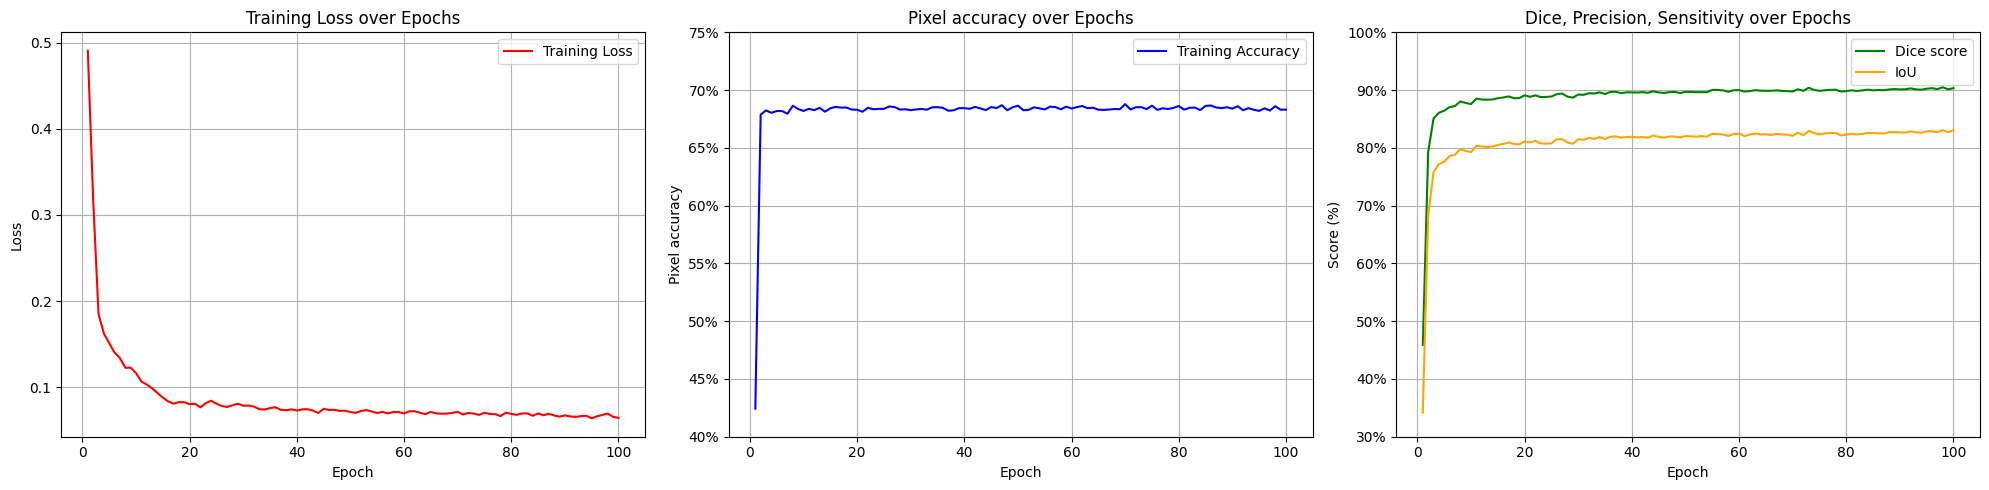

In [52]:
'''---Plotting and Visualizing convergence---'''
it=np.arange(epochs)+1
plt.figure(figsize=(20,5))

'''--- Training loss ---'''
plt.subplot(131)
plt.title('Training Loss over Epochs')
plt.plot(it, train_losses, label='Training Loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

'''--- Pixel Accuracy ---'''
ax2 = plt.subplot(132) 
plt.title('Pixel accuracy over Epochs')
plt.plot(it, train_accuracies, label='Training Accuracy', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Pixel accuracy')
plt.grid(True)
plt.legend()

ticks2 = ax2.get_yticks()
ax2.set_yticks(ticks2)
ax2.set_yticklabels(['{:.0f}%'.format(x*100) for x in ticks2])


'''--- Dice, Precision, Sensitivity ---'''
ax3 = plt.subplot(133) 
plt.title('Dice, Precision, Sensitivity over Epochs')
plt.plot(it, train_dice_score, label='Dice score', color = 'green')
plt.plot(it, train_iou,label = 'IoU', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Score (%)')
plt.grid(True)
plt.legend()

ticks3 = ax3.get_yticks()
ax3.set_yticks(ticks3)
ax3.set_yticklabels(['{:.0f}%'.format(x*100) for x in ticks3])

plt.tight_layout()
plt.show()

### Segmented Output

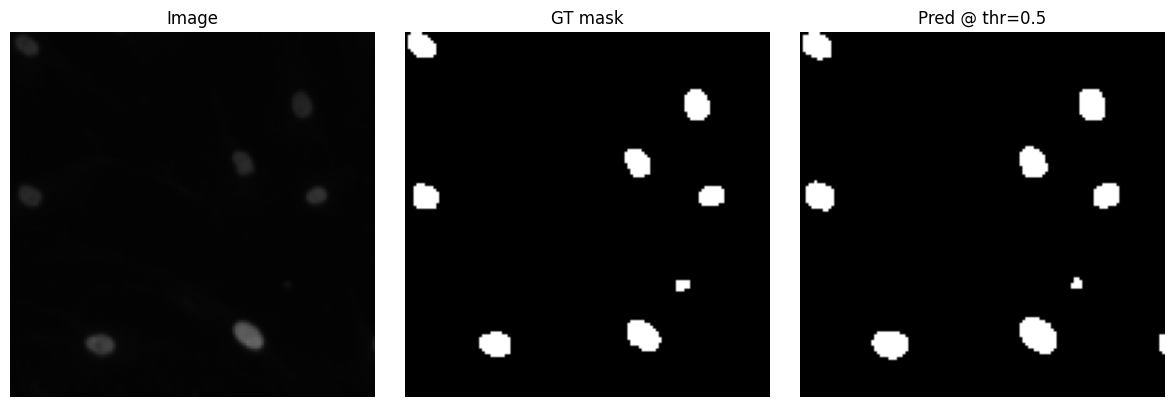

In [81]:
'''Visualizing Segmented Output'''

#DataLoader returns (batch_size,3,H,W) for img and (batch_size,1,H,W) for mask
eval_dl = DataLoader(DSB2018_Dataset(set_type='eval'), batch_size=1, shuffle=True) 

# ---Get one sample---
img, mask = next(iter(eval_dl)) # img: [B,3,H,W], mask: [B,1,H,W] 
img  = img.to(device)
mask = mask.to(device)

if mask.ndim == 4 and mask.shape[1] == 1: mask = mask[:, 0] # -> [B,H,W]
elif mask.ndim != 3:
    raise ValueError("mask must be [B,1,H,W] or [B,H,W] for binary")

# ---Normalized test input---
img_norm = F.normalize(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# --- Handling Deep Supervision and W/O Deep Supervision ---
head_weights = [0.1,0.1,0.2,0.6]
thr = 0.5
model.eval()
with torch.no_grad(): 
    model.deep_supervision= True
    out = model(img_norm) # logits [B,1,H,W] or list of 4 [B,1,H,W]

    #---Deep supervision---
    #Average heads with weights, consistent with the head weights used in loss
    if isinstance(out, (list, tuple)):
        heads = []
        for idx,o in enumerate(out):
            if o.ndim == 4 and o.shape[1] == 1:      # [B,1,H,W]
                heads.append(o[:, 0]*head_weights[idx])                # [B,H,W]
            else: raise ValueError(f"Unexpected head shape: {o.shape}")

        logit = torch.stack(heads, dim=0).mean(dim=0)   # [B,H,W]
    
    #---W/O Deep supervision---
    else:
        if out.ndim == 4 and out.shape[1] == 1:
            logit = out[:, 0,:,:]                         # [B,H,W]
        else: raise ValueError(f"Unexpected output shape: {out.shape}")

    prob = torch.sigmoid(logit)                     # [B,H,W] in [0,1]
    pred = (prob >= thr).float()                     # hard mask [B,H,W]

# ---Convert to CPU---
img_vis  = img[0].detach().permute(1,2,0).cpu().numpy()   # [H,W,3]
mask_vis = mask[0].detach().float().cpu().numpy()         # [H,W]
pred_vis = pred[0].detach().cpu().numpy()                 # [H,W]

# ---Plotting---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img_vis)                        
axs[0].set_title("Image")       
axs[0].axis('off')

axs[1].imshow(mask_vis, cmap='gray', vmin=0, vmax=1)
axs[1].set_title("GT mask")
axs[1].axis('off')

axs[2].imshow(pred_vis, cmap='gray', vmin=0, vmax=1)
axs[2].set_title(f"Pred @ thr={thr}")
axs[2].axis('off')

plt.tight_layout(); plt.show()

